# MINE4201- SR -  Laboratorio 1 
# Exploración modelos KNN



Vamos a utilizar las siguientes librerias en el laboratorio


In [2]:
!pip install "numpy>=1.25.0,<2.0.0"
!pip install scikit-surprise
!pip install pandas
!pip install matplotlib


[notice] A new release of pip is available: 24.3.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [121]:
import os
import numpy as np
import pandas as pd
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import train_test_split
from surprise import KNNBasic
from surprise import accuracy
import random

#Para garantizar reproducibilidad en resultados
seed = 10
random.seed(seed)
np.random.seed(seed)


## Suba al servidor los archivos u.data y u.item que se encuentran en el dataset descargado, en la pestaña files

In [4]:
if not (os.path.exists('./u.data') and os.path.exists('./u.item')):
  raise ValueError('Los archivos u.data e u.item no fueron encontrados en el path')
else:
  print("Los archivos han sido cargados")

Los archivos han sido cargados


In [5]:
ratings=pd.read_csv('./u.data', sep = '\t', names = [ 'user_id', 'item_id', 'rating', 'timestamp' ] )

In [8]:
items=pd.read_csv('./u.item', sep = '\|', names = ['movie id' ,'movie title','release date','video release date','IMDb URL ','unknown',
                                                          'Action','Adventure','Animation','Children','Comedy','Crime','Documentary','Drama',
                                                          'Fantasy','Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western'], encoding='latin-1', engine='python' )

Verifique que los ratings y los items hayan sido cargados correctamente





In [7]:
#ratings.rating=ratings.rating.astype('category')
ratings.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [9]:
items.head()

,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


## Visualice la distribución de ratings, ¿Qué puede decir al respecto?

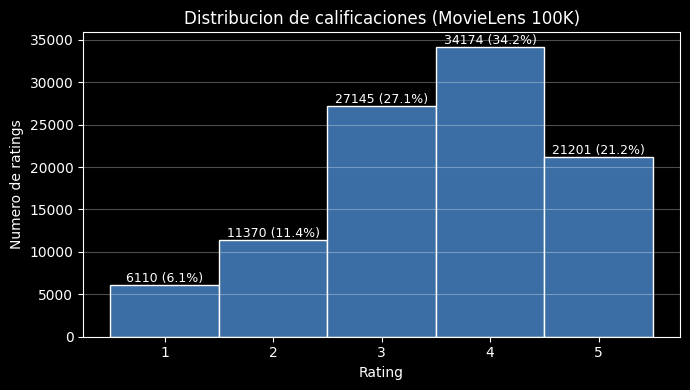

In [16]:
import matplotlib.pyplot as plt

bins = np.arange(0.5, 5.6, 1)
counts = (
    ratings["rating"]
    .value_counts()
    .reindex([1, 2, 3, 4, 5])
    .fillna(0)
    .astype(int)
)
percents = counts / counts.sum() * 100

fig, ax = plt.subplots(figsize=(7, 4))
ax.hist(ratings["rating"], bins=bins, color="#3b6ea5", edgecolor="white")
ax.set(
    title="Distribucion de calificaciones (MovieLens 100K)",
    xlabel="Rating",
    ylabel="Numero de ratings",
)
ax.set_xticks([1, 2, 3, 4, 5])
ax.grid(axis="y", alpha=0.3)

for rect in ax.patches:
    height = rect.get_height()
    center = rect.get_x() + rect.get_width() / 2
    rating_value = int(round(center))
    pct = percents.get(rating_value, 0)
    ax.annotate(
        f"{int(height)} ({pct:.1f}%)",
        (center, height),
        ha="center",
        va="bottom",
        fontsize=9,
    )

plt.tight_layout()


Se observa un sesgo hacia valores medios/altos (típicamente 3 y 4), lo que indica que la mayoría de usuarios tiende a evaluar de forma positiva. Los porcentajes sobre cada barra cuantifican esta concentración y dejan ver que los extremos (1 y 5) son menos frecuentes. Esto sugiere que el dataset no es balanceado en ratings. puede ocurrir que el modelo tienda a predecir ratings altos con mayor frecuencia, lo que podría afectar la precisión de las recomendaciones. Además, la concentración en ratings medios/altos puede dificultar la diferenciación entre items, ya que muchos podrían tener calificaciones similares, lo que podría llevar a recomendaciones menos personalizadas y más genéricas.

In [22]:
ratings.groupby('user_id')['rating'].agg(['count','mean']).sort_values('count', ascending=False)

,count,mean
user_id,,
405,737,1.834464
655,685,2.908029
13,636,3.097484
450,540,3.864815
276,518,3.465251
...,...,...
685,20,2.050000
475,20,3.600000
36,20,3.800000


In [24]:
ratings.groupby('user_id')['rating'].mean().reset_index()

,user_id,rating
0,1,3.610294
1,2,3.709677
2,3,2.796296
3,4,4.333333
4,5,2.874286
...,...,...
938,939,4.265306
939,940,3.457944
940,941,4.045455
941,942,4.265823


## Utilice las siguientes celdas para encontrar respuesta a las siguientes preguntas

¿Cómo es la distribución del número de ratings por usuario?

¿Cómo es la distribución del promedio de calificación por usuario?


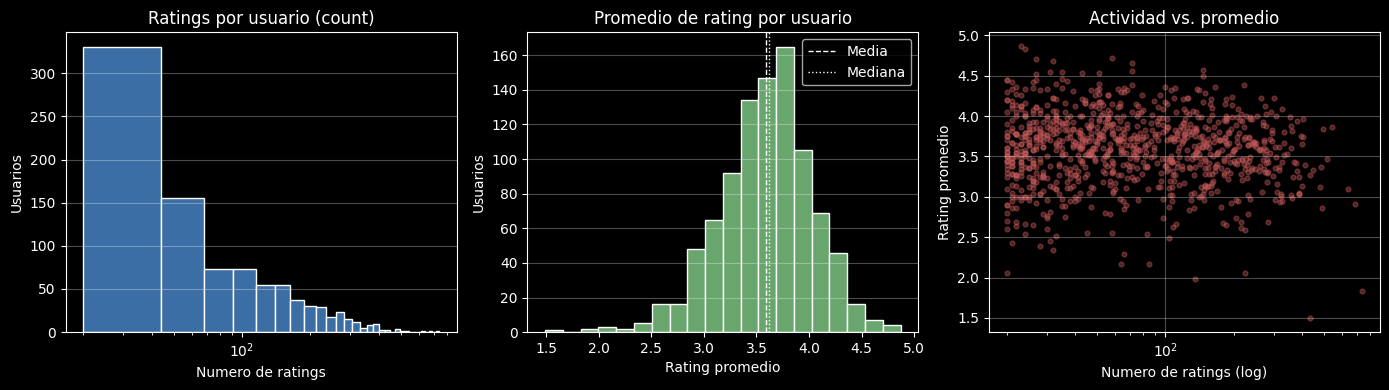

In [33]:
import matplotlib.pyplot as plt

user_stats = ratings.groupby('user_id')['rating'].agg(['count','mean']).reset_index()

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

axes[0].hist(user_stats['count'], bins=30, color="#3b6ea5", edgecolor="white")
axes[0].set(
    title="Ratings por usuario (count)",
    xlabel="Numero de ratings",
    ylabel="Usuarios",
)
axes[0].set_xscale('log')
axes[0].grid(axis='y', alpha=0.3)

axes[1].hist(user_stats['mean'], bins=20, color="#69a66d", edgecolor="white")
axes[1].set(
    title="Promedio de rating por usuario",
    xlabel="Rating promedio",
    ylabel="Usuarios",
)
mean_of_means = user_stats['mean'].mean()
median_of_means = user_stats['mean'].median()

axes[1].axvline(mean_of_means, linestyle="--", linewidth=1, label="Media")
axes[1].axvline(median_of_means, linestyle=":", linewidth=1, label="Mediana")
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

axes[2].scatter(user_stats['count'], user_stats['mean'], alpha=0.4, s=12, color="#c65a5a")
axes[2].set(
    title="Actividad vs. promedio",
    xlabel="Numero de ratings (log)",
    ylabel="Rating promedio",
)
axes[2].set_xscale('log')
axes[2].grid(alpha=0.3)

plt.tight_layout()


In [26]:
# Métricas rápidas de actividad por usuario
count_stats = user_stats['count']
summary = count_stats.describe(percentiles=[0.5, 0.75, 0.9, 0.95])
cold_15 = (count_stats <= 15).mean() * 100
cold_20 = (count_stats <= 20).mean() * 100
cold_30 = (count_stats <= 30).mean() * 100

print("Resumen de count por usuario:\n", summary)
print(f"% usuarios con <=15 ratings: {cold_15:.1f}%")
print(f"% usuarios con <=20 ratings: {cold_20:.1f}%")
print(f"% usuarios con <=30 ratings: {cold_30:.1f}%")


Resumen de count por usuario:
 count    943.000000
mean     106.044539
std      100.931743
min       20.000000
50%       65.000000
75%      148.000000
90%      244.400000
95%      310.600000
max      737.000000
Name: count, dtype: float64
% usuarios con <=15 ratings: 0.0%
% usuarios con <=20 ratings: 3.4%
% usuarios con <=30 ratings: 22.6%


La mayoría de usuarios tienen pocos ratings, y unos pocos usuarios tienen muchísimos.
Hay usuarios más generosos, pero pocos: la mayoría está en un rango razonable.
No hay una relación fuerte entre “cuántas películas califica” y “qué tan alto califica”

Mucha variabilidad, Es más representativa la media que el promedio de ratings por usuario
El dataset está previamente filtrado para eliminar usuarios con muy pocos ratings, peor aún así se observa que el 25% de usuarios tienen entre 20 y 30 ratings.

In [31]:
# 1) Promedio de rating por usuario
mean_rating_per_user = ratings.groupby("user_id")["rating"].mean()

# 2) Resumen estadístico
summary = mean_rating_per_user.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])
print("Resumen del promedio de rating por usuario:\n", summary)


Resumen del promedio de rating por usuario:
 count    943.000000
mean       3.588191
std        0.445233
min        1.491954
5%         2.863739
25%        3.323054
50%        3.620690
75%        3.869565
95%        4.295854
max        4.869565
Name: rating, dtype: float64


Los promedios por usuario se concentran alrededor de 3.6 con dispersión moderada (σ≈0.45); la mitad de los usuarios tiene promedios entre 3.32 y 3.87, con pocos usuarios extremos, lo que sugiere heterogeneidad en la escala personal de calificación y justifica incorporar bias por usuario.

## En la siguiente celda se esta calculando el número de ratings por items, el promedio de sus calificaciones y la varianza de sus calificaciones.

In [34]:
ratings.groupby('item_id')['rating'].agg({'count','mean','var'}).join(items['movie title'], how='left')

,count,var,mean,movie title
item_id,,,,
1,452,0.860992,3.878319,GoldenEye (1995)
2,131,0.934116,3.206107,Four Rooms (1995)
3,90,1.470787,3.033333,Get Shorty (1995)
4,209,0.931358,3.550239,Copycat (1995)
5,86,0.895759,3.302326,Shanghai Triad (Yao a yao yao dao waipo qiao) ...
...,...,...,...,...
1678,1,NaN,1.000000,B. Monkey (1998)
1679,1,NaN,3.000000,Sliding Doors (1998)
1680,1,NaN,2.000000,You So Crazy (1994)


### Utilice las siguientes celdas para encontrar la respuesta a las siguientes preguntas

¿Cuáles son los items con más calificaciones?

¿Se puede observar el fenomeno de cola larga en este dataset?




In [37]:
mt = (ratings.groupby('item_id')['rating']
      .agg(['count','mean','var'])
      .join(items['movie title'], how='left'))

In [38]:
top_items = (mt.sort_values('count', ascending=False)
               .loc[:, ['movie title','count','mean','var']]
               .head(10))
top_items

,movie title,count,mean,var
item_id,,,,
50,Legends of the Fall (1994),583,4.358491,0.776762
258,George of the Jungle (1997),509,3.803536,0.988885
100,Heavy Metal (1981),508,4.155512,0.952100
181,GoodFellas (1990),507,4.007890,0.853693
294,Breakdown (1997),485,3.156701,1.206799
286,Marvin's Room (1996),481,3.656965,1.367498
288,Evita (1996),478,3.441423,1.240796
1,GoldenEye (1995),452,3.878319,0.860992
300,In & Out (1997),431,3.631090,0.996147


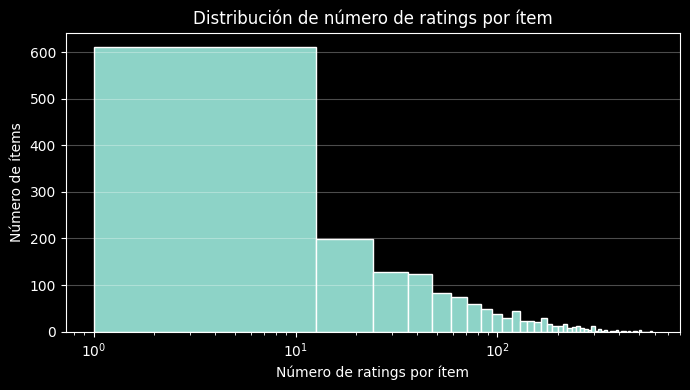

% de ratings en el Top 10 ítems: 4.9%
% de ratings en el Top 10% de ítems: 42.7%


In [47]:
counts = mt['count'].dropna()

plt.figure(figsize=(7,4))
plt.hist(counts, bins=50, edgecolor="white")
plt.xscale('log')
plt.title("Distribución de número de ratings por ítem")
plt.xlabel("Número de ratings por ítem")
plt.ylabel("Número de ítems")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

total_ratings = counts.sum()
share_top_10 = counts.sort_values(ascending=False).head(10).sum() / total_ratings * 100
share_top_10pct = counts.sort_values(ascending=False).head(int(len(counts)*0.10)).sum() / total_ratings * 100

print(f"% de ratings en el Top 10 ítems: {share_top_10:.1f}%")
print(f"% de ratings en el Top 10% de ítems: {share_top_10pct:.1f}%")

Los ítems con más calificaciones corresponden a las películas más populares del dataset (las que concentran más interacciones). Al ordenar por count, se observa que existe un grupo pequeño de películas “top” con cientos de ratings, mientras que la mayoría no alcanza esos niveles de popularidad. Esto indica que la interacción no está distribuida de forma uniforme entre películas: unas pocas reciben mucha atención y muchas reciben poca.

## Creación de listas de recomendación no personalizadas

Genere inicialmente una lista de recomendación de tamaño 10 no personalizada con los items con mejor promedio, en teoría estos son los mejores items del dataset.

¿Qué problemas tiene generar una lista no personalizada solamente con el promedio?

¿Es posible generar una mejor lista de recomendación teniendo en cuenta que tanto el número de ratings del item como su promedio?

Ver: 

http://www.evanmiller.org/how-not-to-sort-by-average-rating.html

https://es.wikipedia.org/wiki/Intervalo_de_confianza


In [56]:
top10_mean = (item_stats
              .merge(items[['movie title']], left_on='item_id', right_index=True, how='left')
              .sort_values(['mean','count'], ascending=[False, False])
              .head(10))

top10_mean[['movie title','mean','count']]



,movie title,mean,count
1188,That Old Feeling (1997),5.0,3
1292,Ayn Rand: A Sense of Life (1997),5.0,3
1466,"Cure, The (1995)",5.0,2
1499,Prisoner of the Mountains (Kavkazsky Plennik) ...,5.0,2
813,One Fine Day (1996),5.0,1
1121,"Last Time I Saw Paris, The (1954)",5.0,1
1200,"Maybe, Maybe Not (Bewegte Mann, Der) (1994)",5.0,1
1535,Cosi (1996),5.0,1
1598,Guantanamera (1994),5.0,1
1652,Chairman of the Board (1998),5.0,1


1. Sesgo por baja cantidad de ratings (promedios inflados): una película con 1–5 calificaciones puede tener promédio 5.0 y aparecer arriba, pero es poco confiable. Si no se considera el número de ratings, se corre el riesgo de recomendar ítems con alta calificación pero poca interacción, lo que puede resultar en recomendaciones de baja calidad o relevancia para los usuarios. El promedio por sí solo no distingue confianza.
2. No es personalizado: ignora gustos del usuario. Un top global puede recomendar géneros que el usuario detesta (ej. terror), aunque el promedio sea alto.
3. No se tienen en cuenta sesgos de calificación: algunos usuarios pueden ser más generosos o estrictos, lo que afecta el promedio sin reflejar la calidad real del ítem.
4. Rankings por promedio son vulnerables a manipulación (pocas calificaciones altas suben mucho el promedio).

In [89]:
# 0.1) Índice correcto para títulos
items_idx = (
    items.rename(columns={"movie id": "item_id"})
         .set_index("item_id")
)

# 0.2) Validación de títulos (join correcto)
def validate_titles(ratings: pd.DataFrame, items_idx: pd.DataFrame) -> None:
    unique_items = ratings["item_id"].nunique()
    missing = unique_items - ratings["item_id"].isin(items_idx.index).sum()
    print(f"Items únicos en ratings: {unique_items}")
    print(f"Items sin título: {missing} ({missing/unique_items*100:.2f}%)")

    check = ratings[["item_id"]].drop_duplicates().join(items_idx["movie title"], on="item_id", how="left")
    print(f"% títulos NaN tras join: {check['movie title'].isna().mean()*100:.2f}%")

validate_titles(ratings, items_idx)

# 0.3) Features por ítem reutilizables (para IC + Bayes)
mt = (
    ratings.groupby("item_id")["rating"]
           .agg(count="count", mean="mean", var="var")
           .join(items_idx["movie title"], how="left")
)

Items únicos en ratings: 1682
Items sin título: -98318 (-5845.30%)
% títulos NaN tras join: 0.00%


In [91]:
def rank_wilson(
    ratings: pd.DataFrame,
    items_idx: pd.DataFrame,
    threshold: int = 4,
    z: float = 1.96,
    top_n: int = 10
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Ranking por Wilson lower bound (proporción de 'likes' con intervalo de Wilson).
    Devuelve (ranking_completo, top_n).
    """
    tmp = ratings.assign(positive=(ratings["rating"] >= threshold).astype(int))
    pn = tmp.groupby("item_id")["positive"].agg(pos="sum", n="count")

    phat = pn["pos"] / pn["n"]
    n = pn["n"]

    pn["wilson_lb"] = (
        (phat + z*z/(2*n) - z*np.sqrt((phat*(1-phat) + z*z/(4*n))/n)) /
        (1 + z*z/n)
    )

    rank = pn.join(items_idx["movie title"], how="left").sort_values("wilson_lb", ascending=False)
    top = rank.head(top_n)[["movie title", "pos", "n", "wilson_lb"]]
    return rank, top

rank_full_wilson, top10_wilson = rank_wilson(ratings, items_idx)
top10_wilson


,movie title,pos,n,wilson_lb
item_id,,,,
64,"Shawshank Redemption, The (1994)",255,283,0.860720
479,Vertigo (1958),162,179,0.853178
318,Schindler's List (1993),265,298,0.848560
98,"Silence of the Lambs, The (1991)",344,390,0.846252
483,Casablanca (1942),216,243,0.843166
603,Rear Window (1954),185,209,0.834823
427,To Kill a Mockingbird (1962),193,219,0.831730
50,Star Wars (1977),501,583,0.828769
357,One Flew Over the Cuckoo's Nest (1975),230,264,0.825420


In [93]:
def rank_ci_mean_lcb(
    mt: pd.DataFrame,
    z: float = 1.96,
    min_count: int = 50,
    top_n: int = 10
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Ranking por límite inferior del IC (aprox normal) para la media del ítem.
    Usa columnas: count, mean, var, movie title.
    """
    df = mt[mt["count"] >= max(min_count, 2)].copy()
    df["std"] = np.sqrt(df["var"].fillna(0))
    df["lcb_mean"] = df["mean"] - z * (df["std"] / np.sqrt(df["count"]))

    rank = df.sort_values("lcb_mean", ascending=False)
    top = rank.head(top_n)[["movie title", "count", "mean", "lcb_mean"]]
    return rank, top

rank_full_ci, top10_ci_mean = rank_ci_mean_lcb(mt, min_count=50)
top10_ci_mean


,movie title,count,mean,lcb_mean
item_id,,,,
318,Schindler's List (1993),298,4.466443,4.372306
483,Casablanca (1942),243,4.456790,4.365241
64,"Shawshank Redemption, The (1994)",283,4.445230,4.355866
408,"Close Shave, A (1995)",112,4.491071,4.348271
169,"Wrong Trousers, The (1993)",118,4.466102,4.317496
603,Rear Window (1954),209,4.387560,4.290955
50,Star Wars (1977),583,4.358491,4.286948
12,"Usual Suspects, The (1995)",267,4.385768,4.286749
114,Wallace & Gromit: The Best of Aardman Animatio...,67,4.447761,4.264717


In [94]:
def rank_bayesian_average(
    mt: pd.DataFrame,
    global_mean: float,
    m_quantile: float = 0.90,
    top_n: int = 10
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Weighted/Bayesian average: score = (v/(v+m))*R + (m/(v+m))*C
    """
    df = mt.copy()
    m = df["count"].quantile(m_quantile)

    df["score_bayes"] = (df["count"]/(df["count"]+m))*df["mean"] + (m/(df["count"]+m))*global_mean
    rank = df.sort_values("score_bayes", ascending=False)

    top = rank.head(top_n)[["movie title", "count", "mean", "score_bayes"]]
    return rank, top

C = ratings["rating"].mean()
rank_full_bayes, top10_bayes = rank_bayesian_average(mt, global_mean=C, m_quantile=0.90)
top10_bayes


,movie title,count,mean,score_bayes
item_id,,,,
50,Star Wars (1977),583,4.358491,4.172269
318,Schindler's List (1993),298,4.466443,4.127508
64,"Shawshank Redemption, The (1994)",283,4.445230,4.102979
483,Casablanca (1942),243,4.456790,4.076569
127,"Godfather, The (1972)",413,4.283293,4.064513
98,"Silence of the Lambs, The (1991)",390,4.289744,4.060011
12,"Usual Suspects, The (1995)",267,4.385768,4.054005
174,Raiders of the Lost Ark (1981),420,4.252381,4.045070
313,Titanic (1997),350,4.245714,4.012613


In [95]:
def rank_miller_star(
    ratings: pd.DataFrame,
    items_idx: pd.DataFrame,
    K: int = 5,
    z: float = 1.65,
    top_n: int = 10
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Ranking 'star ratings' de Evan Miller con Dirichlet(1..1) + LCB.
    Devuelve (ranking_completo, top_n).
    """
    s = np.arange(1, K + 1)
    nk = pd.crosstab(ratings["item_id"], ratings["rating"]).reindex(columns=s, fill_value=0)
    N = nk.sum(axis=1)

    p = (nk + 1).div(N + K, axis=0)
    mu = (p * s).sum(axis=1)
    m2 = (p * (s**2)).sum(axis=1)
    var = (m2 - mu**2) / (N + K + 1)

    score = mu - z * np.sqrt(var)

    rank = pd.DataFrame({"count": N, "bayes_mean": mu, "score": score})
    rank.index.name = "item_id"
    rank = rank.join(items_idx["movie title"], how="left").sort_values("score", ascending=False)

    top = rank.head(top_n)[["movie title", "count", "bayes_mean", "score"]]
    return rank, top

rank_full_miller, top10_miller = rank_miller_star(ratings, items_idx)
top10_miller


,movie title,count,bayes_mean,score
item_id,,,,
318,Schindler's List (1993),298,4.442244,4.360743
483,Casablanca (1942),243,4.427419,4.346453
64,"Shawshank Redemption, The (1994)",283,4.420139,4.342105
408,"Close Shave, A (1995)",112,4.427350,4.296646
50,Star Wars (1977),583,4.346939,4.286076
12,"Usual Suspects, The (1995)",267,4.360294,4.274515
169,"Wrong Trousers, The (1993)",118,4.406504,4.273117
603,Rear Window (1954),209,4.355140,4.269134
98,"Silence of the Lambs, The (1991)",390,4.273418,4.202315


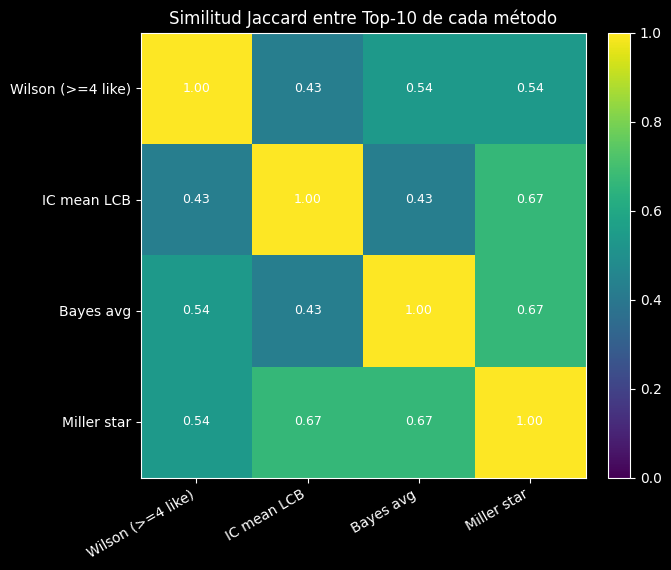

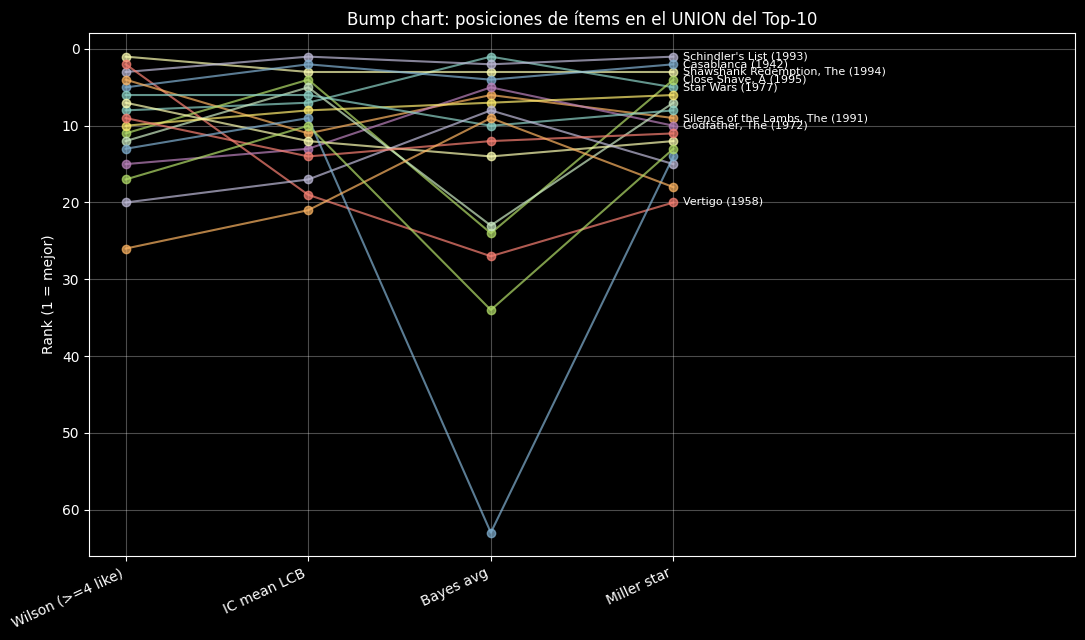

,movie title,Wilson (>=4 like),IC mean LCB,Bayes avg,Miller star
50,Star Wars (1977),8.0,7.0,1.0,5.0
64,"Shawshank Redemption, The (1994)",1.0,3.0,3.0,3.0
318,Schindler's List (1993),3.0,1.0,2.0,1.0
479,Vertigo (1958),2.0,19.0,27.0,20.0
483,Casablanca (1942),5.0,2.0,4.0,2.0
98,"Silence of the Lambs, The (1991)",4.0,11.0,6.0,9.0
408,"Close Shave, A (1995)",11.0,4.0,24.0,4.0
127,"Godfather, The (1972)",15.0,13.0,5.0,10.0
169,"Wrong Trousers, The (1993)",12.0,5.0,23.0,7.0
12,"Usual Suspects, The (1995)",10.0,8.0,7.0,6.0


In [98]:
TOP_N = 10

# 1) Recalcular rankings (ajusta parámetros a gusto)
rank_full_wilson, top_wilson = rank_wilson(ratings, items_idx, threshold=4, z=1.96, top_n=TOP_N)

# Importante: usa min_count para evitar items con 2 ratings perfectos dominando el ranking
rank_full_ci, top_ci = rank_ci_mean_lcb(mt, z=1.96, min_count=50, top_n=TOP_N)

C = ratings["rating"].mean()
rank_full_bayes, top_bayes = rank_bayesian_average(mt, global_mean=C, m_quantile=0.90, top_n=TOP_N)

rank_full_miller, top_miller = rank_miller_star(ratings, items_idx, K=5, z=1.65, top_n=TOP_N)

# 2) Diccionario de métodos -> score (Series)
methods = {
    "Wilson (>=4 like)": rank_full_wilson["wilson_lb"],
    "IC mean LCB": rank_full_ci["lcb_mean"],
    "Bayes avg": rank_full_bayes["score_bayes"],
    "Miller star": rank_full_miller["score"],
}

# 3) Construir Top-N sets por método
top_sets = {
    name: set(score.sort_values(ascending=False).head(TOP_N).index)
    for name, score in methods.items()
}

names = list(methods.keys())

# =========================
# A) HEATMAP JACCARD TOP-N
# =========================
jacc = np.zeros((len(names), len(names)))

for i, a in enumerate(names):
    for j, b in enumerate(names):
        A, B = top_sets[a], top_sets[b]
        inter = len(A & B)
        union = len(A | B)
        jacc[i, j] = inter / union if union else 0.0

fig, ax = plt.subplots(figsize=(7, 5.8))
im = ax.imshow(jacc, vmin=0, vmax=1)

ax.set_xticks(range(len(names)))
ax.set_xticklabels(names, rotation=30, ha="right")
ax.set_yticks(range(len(names)))
ax.set_yticklabels(names)

ax.set_title(f"Similitud Jaccard entre Top-{TOP_N} de cada método")

for i in range(len(names)):
    for j in range(len(names)):
        ax.text(j, i, f"{jacc[i,j]:.2f}", ha="center", va="center", fontsize=9)

fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

# ==========================================
# B) BUMP CHART: RANKS EN UNION DEL TOP-N
# ==========================================
union_items = sorted(set().union(*top_sets.values()))

rank_df = pd.DataFrame(index=union_items)

for name, score in methods.items():
    # rank global (1 = mejor)
    r = score.rank(ascending=False, method="min")
    # reindex al union
    r_u = r.reindex(union_items)

    # si un item no existe en el método (por filtros), lo ponemos como "peor que el peor"
    worst_rank = r.max() + 1
    rank_df[name] = r_u.fillna(worst_rank)

# agregar título para poder inspeccionar/etiquetar
rank_df = rank_df.join(items_idx["movie title"], how="left")

# ordenar por el mejor rank alcanzado en cualquier método (para que el gráfico quede más legible)
rank_df["best_rank"] = rank_df[names].min(axis=1)
rank_df = rank_df.sort_values("best_rank")

x = np.arange(len(names))

fig, ax = plt.subplots(figsize=(11, 6.5))

for item_id, row in rank_df.iterrows():
    y = row[names].values.astype(float)
    ax.plot(x, y, marker="o", alpha=0.7)

ax.invert_yaxis()
ax.set_xticks(x)
ax.set_xticklabels(names, rotation=25, ha="right")
ax.set_ylabel("Rank (1 = mejor)")
ax.set_title(f"Bump chart: posiciones de ítems en el UNION del Top-{TOP_N}")
ax.grid(alpha=0.3)

# Etiquetar algunos (los mejores según best_rank) para no saturar
label_k = min(8, len(rank_df))
for item_id, row in rank_df.head(label_k).iterrows():
    ax.text(x[-1] + 0.05, row[names[-1]], row["movie title"], va="center", fontsize=8)

ax.set_xlim(-0.2, len(names) - 1 + 2.2)
plt.tight_layout()
plt.show()

# (Opcional) tabla para inspección
rank_df[["movie title"] + names].head(20)


In [101]:
# top_sets: dict { "Metodo": set(item_id) }
# items_idx: DataFrame index=item_id con columna "movie title"

# 1) Unión de todos los items que aparecen en algún top-10
union_items = sorted(set().union(*top_sets.values()))
methods = list(top_sets.keys())

# 2) Tabla booleana: aparece o no aparece en el Top-10 de cada método
overlap = pd.DataFrame(index=union_items)

for m in methods:
    overlap[m] = overlap.index.isin(top_sets[m])

# 3) Agregar título y métricas resumen
overlap = overlap.join(items_idx["movie title"], how="left")
overlap["num_metodos"] = overlap[methods].sum(axis=1)

# Lista de métodos en los que aparece
overlap["metodos"] = overlap[methods].apply(
    lambda row: ", ".join([m for m in methods if row[m]]),
    axis=1
)

# 4) Ordenar: primero los que aparecen en más métodos
overlap = overlap.reset_index().rename(columns={"index": "item_id"})
overlap = overlap.sort_values(["num_metodos", "movie title"], ascending=[False, True])

# Mostrar columnas “bonitas”
cols = ["item_id", "movie title", "num_metodos", "metodos"] + methods
overlap[cols]


,item_id,movie title,num_metodos,metodos,Wilson (>=4 like),IC mean LCB,Bayes avg,Miller star
15,483,Casablanca (1942),4,"Wilson (>=4 like), IC mean LCB, Bayes avg, Mil...",True,True,True,True
16,603,Rear Window (1954),4,"Wilson (>=4 like), IC mean LCB, Bayes avg, Mil...",True,True,True,True
10,318,Schindler's List (1993),4,"Wilson (>=4 like), IC mean LCB, Bayes avg, Mil...",True,True,True,True
2,64,"Shawshank Redemption, The (1994)",4,"Wilson (>=4 like), IC mean LCB, Bayes avg, Mil...",True,True,True,True
1,50,Star Wars (1977),4,"Wilson (>=4 like), IC mean LCB, Bayes avg, Mil...",True,True,True,True
0,12,"Usual Suspects, The (1995)",4,"Wilson (>=4 like), IC mean LCB, Bayes avg, Mil...",True,True,True,True
3,98,"Silence of the Lambs, The (1991)",3,"Wilson (>=4 like), Bayes avg, Miller star",True,False,True,True
12,408,"Close Shave, A (1995)",2,"IC mean LCB, Miller star",False,True,False,True
5,127,"Godfather, The (1972)",2,"Bayes avg, Miller star",False,False,True,True
6,169,"Wrong Trousers, The (1993)",2,"IC mean LCB, Miller star",False,True,False,True


## Comparación de 4 métodos de ranking no personalizado (Top-10)

Para construir listas de recomendación **no personalizadas** (mismas recomendaciones para todos los usuarios), se evaluaron cuatro estrategias que intentan corregir el problema de **ordenar solo por promedio**: los ítems con pocas calificaciones pueden aparecer artificialmente “mejores” por azar.

### Métodos evaluados

1) **Wilson Lower Bound (Evan Miller – “How Not To Sort By Average Rating”)**
- Convierte las calificaciones a una variable binaria: *like* si `rating ≥ 4`.
- Rankea por el **límite inferior** del intervalo de Wilson para la proporción de likes.
- Ventaja: penaliza de forma natural a ítems con pocos votos (alta incertidumbre).
- Interpretación: “probabilidad mínima plausible” de que una calificación sea positiva.

2) **IC para la media (Wikipedia – LCB del intervalo de confianza)**
- Calcula el límite inferior del IC de la media:
  \[
  \text{LCB} = \bar{x} - z\cdot \frac{s}{\sqrt{n}}
  \]
- Integra `mean`, `var` y `count`: a mayor `n`, menor incertidumbre.
- Nota práctica: para evitar ítems con `var=0` y `n` pequeño dominando el ranking, se aplicó un **mínimo de calificaciones** (`min_count`) para hacer el ranking más robusto.

3) **Bayesian Average / Shrinkage (tipo IMDb)**
- Regulariza el promedio del ítem hacia la media global `C`:
  \[
  \text{score} = \frac{v}{v+m}R + \frac{m}{v+m}C
  \]
- Donde `v=count`, `R=mean` y `m` controla qué tan fuerte es el prior.
- Ventaja: evita “promedios inflados” cuando `count` es bajo, sin necesidad de binarizar.

4) **Miller Star Ratings (Evan Miller – ranking para 1–5 estrellas)**
- Usa la distribución completa de estrellas (1..5), aplica suavizamiento Bayesiano (Dirichlet) y rankea con un límite inferior conservador.
- Ventaja: no pierde información al binarizar (como Wilson) y penaliza incertidumbre de manera explícita.

---

### Hallazgos principales

#### 1) Consenso parcial entre métodos (Heatmap Jaccard)
La similitud Jaccard entre Top-10 muestra **acuerdo moderado**:
- **Bayes avg ↔ Miller star**: Jaccard ≈ **0.67** (son los más parecidos).
- **IC mean LCB ↔ Miller star**: Jaccard ≈ **0.67** (también alto).
- **Wilson ↔ (Bayes/Miller)**: Jaccard ≈ **0.54**.
- **Wilson ↔ IC mean LCB**: Jaccard ≈ **0.43** (menor coincidencia).

**Interpretación:**
- Los métodos que trabajan en escala de 1–5 con regularización (Bayes avg y Miller star) tienden a recomendar conjuntos muy similares.
- Wilson difiere más porque mide “consistencia de likes” (>=4) y no el promedio directo.

#### 2) Estabilidad vs cambios en posiciones (Bump chart)
El bump chart evidencia que:
- Algunas películas mantienen posiciones competitivas en casi todos los métodos (alta estabilidad).
- Otras cambian fuertemente de posición, lo cual indica que el método está priorizando una noción distinta de “mejor”:
  - **Wilson** favorece ítems con alta proporción de likes de forma consistente.
  - **Bayes/Miller-star** favorecen ítems con alto rating esperado y soporte suficiente.
  - **IC mean LCB** es muy sensible al tratamiento de ítems con baja varianza / bajo `count` (por eso se recomienda un `min_count`).

#### 3) Películas recurrentes (overlap entre Top-10)
Se observa un **núcleo de películas** que aparece repetidamente en varios métodos (consenso).
En particular, varias películas aparecen en **todos los métodos**, lo que sugiere que son fuertes candidatas para una lista global no personalizada (alta calidad + buen soporte + consistencia).

---

### Conclusión
- Ordenar solo por promedio no es robusto cuando hay pocos ratings por ítem.
- **Bayesian average** y **Miller star ratings** resultan los enfoques más consistentes entre sí y generalmente más “razonables” para rankings 1–5.
- **Wilson** es útil cuando se desea rankear por una noción tipo “porcentaje de usuarios satisfechos” (like/no-like), y suele producir un top con énfasis en consistencia.
- **IC mean LCB** es válido como aproximación, pero requiere cuidado (p. ej., `min_count`) para evitar que ítems con poca evidencia dominen el ranking.

En conjunto, los resultados confirman que incorporar **incertidumbre** (vía intervalos, shrinkage o límites inferiores) produce rankings globales más confiables que el promedio simple.


# Creación del dataset de entrenamiento y prueba

El próximo paso es cargar los datos a surprise, para esto vamos a inicializar un modelo de datos de surprise con la información de los ratings cargados en el dataframe

In [122]:
reader = Reader( rating_scale = ( 1, 5 ) )
#Se crea el dataset a partir del dataframe
surprise_dataset = Dataset.load_from_df( ratings[ [ 'user_id', 'item_id', 'rating' ] ], reader )

Se divide el dataset en entrenamiento y test. El dataset de entrenamiento será presentado al algoritmo de recomendación y el dataset de test nos servirá para medir qué tan buenas fueron las predicciones del sistema de recomendación. El conjunto de test generado es una lista con los ratings de prueba

In [123]:
train_set, test_set=  train_test_split(surprise_dataset, test_size=.2)

In [124]:
train_set.n_ratings

80000

In [125]:
len(test_set)

20000

In [126]:
#Este es el primer elemento del dataset de prueba (usuario 154, película 302, rating 4)
test_set[0]

(154, 302, 4.0)

## Creación de modelo de filtrado colaborativo basado en similitud con usuarios o items cercanos

Surprise cuenta con la implementación de los modelos colaborativos dentro de la clase [KNNBasic](https://surprise.readthedocs.io/en/stable/knn_inspired.html) 

El modelo recibe los siguientes parámetros: 


*   k: El máximo número de vecinos con el que se hará la extrapolación
*   min_k : El mínimo número de vecinos con el que se extrapolará un rating
*   sim_options : Opciones de similitud pasadas como un diccionario de python, aqui se le configura al modelo el tipo de similitud a usar para encontrar los vecinos y si la extrapolación debe hacerse usando usuarios o items similares. Revise el formato y similitudes disponibles en surprise en [este link](https://surprise.readthedocs.io/en/stable/prediction_algorithms.html#similarity-measure-configuration)





In [127]:
# se crea un modelo knnbasic item-item con similitud coseno 
sim_options = {'name': 'cosine',
               'user_based': False  # calcule similitud item-item
               }
algo = KNNBasic(k=20, min_k=2, sim_options=sim_options)

In [128]:
#Se le pasa la matriz de utilidad al algoritmo 
algo.fit(trainset=train_set)

Computing the cosine similarity matrix...
Done computing similarity matrix.


Una vez cargados los ratings al modelo, se puede realizar una predicción para un usuario, en este caso vamos a calcular la predicción que el modelo esta realizando para la primera entrada del dataset de test la predicción para el usuario con id 154 y el item con id 302, que corresponde a la película L.A. Confidential (1997)

---



In [129]:
#Verifique la propiedad est de la predicción
algo.predict(154,302)

Prediction(uid=154, iid=302, r_ui=None, est=4.249202065377386, details={'actual_k': 20, 'was_impossible': False})

In [130]:
items[items['movie id']==302]

,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
301,302,L.A. Confidential (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?L%2EA%2E+Conf...,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0


Como podemos ver, la predicción (4.24) del modelo no esta alejada de lo que realmente opinó el usuario  (4.0)

Para medir la calidad de la predicción para todos los usuarios e items del dataset de prueba, vamos a comparar lo que dice el modelo de predicción vs lo que dice el conjunto de prueba, para esto vamos a usar la métrica [RMSE](https://surprise.readthedocs.io/en/stable/accuracy.html#surprise.accuracy.rmse)

Inicialmente calculamos la predicción para todos los elementos del conjunto de test

In [131]:
test_predictions=algo.test(test_set)

In [132]:
#5 primeras predicciones
test_predictions[0:5]

[Prediction(uid=154, iid=302, r_ui=4.0, est=4.249202065377386, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=896, iid=484, r_ui=4.0, est=2.8976616922320964, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=230, iid=371, r_ui=4.0, est=4.1968378983432535, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=234, iid=294, r_ui=3.0, est=3.0978778071364186, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=25, iid=729, r_ui=4.0, est=4.148885433441103, details={'actual_k': 20, 'was_impossible': False})]

Ahora se mide el RMSE de las predicciones vs el valor del dataset

In [134]:
# En promedio, el sistema encuentra ratings que están una estrella por encima o por debajo del rating del usuario
accuracy.rmse( test_predictions, verbose = True )

RMSE: 1.0453


1.0453343976192102

## Utilice las siguientes celdas para encontrar la respuesta a las siguientes preguntas

¿Cuál es el RMSE de un modelo usuario-usuario con los mismos parámetros de similitud?

¿Cuál es el efecto de cambiar el número de vecinos en la calidad del modelo usuario-usuario ?

In [137]:
# Modelo KNNBasic usuario-usuario con similitud coseno (mismos hiperparámetros)
sim_options_uu = {
    "name": "cosine",
    "user_based": True
}

algo_uu = KNNBasic(k=20, min_k=2, sim_options=sim_options_uu)

algo_uu.fit(train_set)

test_predictions_uu = algo_uu.test(test_set)

rmse_uu = accuracy.rmse(test_predictions_uu, verbose=True)
rmse_uu

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0166


1.0166414414593592

En user–user, para predecir un ítem popular es fácil encontrar 20 usuarios que lo hayan calificado.
En item–item, para un usuario con pocas calificaciones, puede ser más difícil encontrar suficientes ítems realmente similares al ítem objetivo.

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


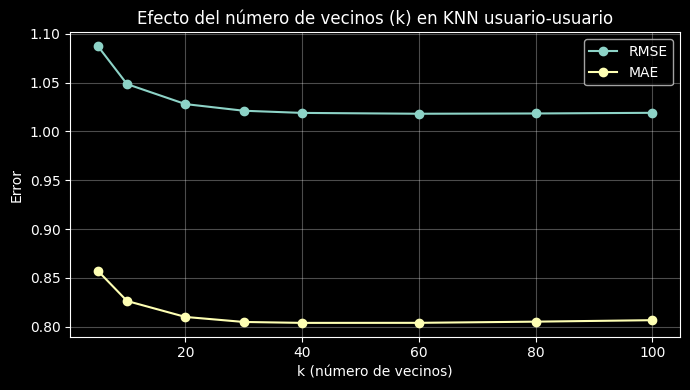

,k,RMSE,MAE
5,60,1.018176,0.803973
6,80,1.018451,0.805179
4,40,1.019035,0.803922
7,100,1.019133,0.806693
3,30,1.021254,0.804871
2,20,1.028066,0.810010
1,10,1.048534,0.826347
0,5,1.087404,0.857228


In [138]:
# 1) dataset + split reproducible
reader = Reader(rating_scale=(1, 5))
surprise_dataset = Dataset.load_from_df(ratings[['user_id', 'item_id', 'rating']], reader)

train_set, test_set = train_test_split(surprise_dataset, test_size=0.2, random_state=42)

# 2) rango de k a evaluar
k_values = [5, 10, 20, 30, 40, 60, 80, 100]

rmse_values = []
mae_values = []

sim_options = {
    "name": "cosine",
    "user_based": True  # usuario-usuario
}

for k in k_values:
    algo = KNNBasic(k=k, min_k=2, sim_options=sim_options)
    algo.fit(train_set)
    preds = algo.test(test_set)

    rmse = accuracy.rmse(preds, verbose=False)
    mae  = accuracy.mae(preds, verbose=False)

    rmse_values.append(rmse)
    mae_values.append(mae)

# 3) gráfica
plt.figure(figsize=(7,4))
plt.plot(k_values, rmse_values, marker="o", label="RMSE")
plt.plot(k_values, mae_values, marker="o", label="MAE")
plt.title("Efecto del número de vecinos (k) en KNN usuario-usuario")
plt.xlabel("k (número de vecinos)")
plt.ylabel("Error")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# 4) tabla resumen (opcional)
results = pd.DataFrame({"k": k_values, "RMSE": rmse_values, "MAE": mae_values}).sort_values("RMSE")
results

Cuando k es pequeño (5–10) el error es más alto.
Con pocos vecinos, la predicción depende mucho de 2–3 usuarios “parecidos” → más ruido (alta varianza).

Al subir k hasta ~30–40, RMSE y MAE bajan rápido.
Al agregar más evidencia se promedia mejor.

A partir de k≈40, la curva se aplana (mejoras marginales casi nulas).
Ya se están incluyendo vecinos menos similares.

## Generando listas de predicciones para los usuarios

Retomemos nuestro modelo inicial y ajustémolo con todos los ratings disponibles

Para generar una lista de recomendación se debe crear un dataset de "test" con las entradas faltantes de la matriz utilidad para que el modelo cree las predicciones (terminar de llenar la matriz de utilidad)



In [140]:
#Se crea el dataset para modelo 
rating_data=surprise_dataset.build_full_trainset()
# Se crea dataset de "prueba" con las entradas faltantes para generar las predicciones
test=rating_data.build_anti_testset()

# se crea el mismo modelo que el del ejemplo
sim_options = {'name': 'cosine',
               'user_based': False  # calcule similitud item-item
               }
algo = KNNBasic(k=20, min_k=2, sim_options=sim_options)
algo.fit(rating_data)
predictions=algo.test(test)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [141]:
#10 primeras predicciones
predictions[0:10]

[Prediction(uid=196, iid=302, r_ui=3.52986, est=3.4998074068929244, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=196, iid=377, r_ui=3.52986, est=3.531852919263047, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=196, iid=51, r_ui=3.52986, est=3.59549677885145, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=196, iid=346, r_ui=3.52986, est=3.5471070543165877, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=196, iid=474, r_ui=3.52986, est=3.7990088769026116, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=196, iid=265, r_ui=3.52986, est=3.4464297466659812, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=196, iid=465, r_ui=3.52986, est=3.5022156502733557, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=196, iid=451, r_ui=3.52986, est=3.6948301041629965, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=196, iid=86, r_ui=3.52986, e

In [142]:
#Predicciones para usuario 196
user_predictions=list(filter(lambda x: x[0]==196,predictions))

In [143]:
#Ordenamos de mayor a menor estimación de relevancia
user_predictions.sort(key=lambda x : x.est, reverse=True)

In [144]:
#tomamos las 10 primeras predicciones
user_predictions=user_predictions[0:10]

In [145]:
user_predictions

[Prediction(uid=196, iid=1309, r_ui=3.52986, est=4.5, details={'actual_k': 4, 'was_impossible': False}),
 Prediction(uid=196, iid=1310, r_ui=3.52986, est=4.5, details={'actual_k': 4, 'was_impossible': False}),
 Prediction(uid=196, iid=1676, r_ui=3.52986, est=4.25, details={'actual_k': 8, 'was_impossible': False}),
 Prediction(uid=196, iid=1675, r_ui=3.52986, est=4.25, details={'actual_k': 8, 'was_impossible': False}),
 Prediction(uid=196, iid=1289, r_ui=3.52986, est=4.202435603862276, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=196, iid=1643, r_ui=3.52986, est=4.097225899300029, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=196, iid=1593, r_ui=3.52986, est=4.090909090909091, details={'actual_k': 11, 'was_impossible': False}),
 Prediction(uid=196, iid=935, r_ui=3.52986, est=4.05136705364539, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=196, iid=1216, r_ui=3.52986, est=4.0506920732628675, details={'actual_k': 20, 'was_i

In [146]:
#Se convierte a dataframe
labels = ['movie id', 'estimation']
df_predictions = pd.DataFrame.from_records(list(map(lambda x: (x.iid, x.est) , user_predictions)), columns=labels)

In [147]:
#Lo unimos con el dataframe de películas
df_predictions.merge(items[['movie id','movie title','IMDb URL ']], how='left', on='movie id')

,movie id,estimation,movie title,IMDb URL
0,1309,4.500000,"Very Natural Thing, A (1974)",http://us.imdb.com/M/title-exact?Very%20Natura...
1,1310,4.500000,"Walk in the Sun, A (1945)",http://us.imdb.com/M/title-exact?Walk%20in%20t...
2,1676,4.250000,"War at Home, The (1996)",http://us.imdb.com/M/title-exact?War%20at%20Ho...
3,1675,4.250000,"Sunchaser, The (1996)","http://us.imdb.com/M/title-exact?Sunchaser,%20..."
4,1289,4.202436,Jack and Sarah (1995),http://us.imdb.com/M/title-exact?Jack%20and%20...
5,1643,4.097226,Angel Baby (1995),http://us.imdb.com/Title?Angel+Baby+(1995/I)
6,1593,4.090909,Death in Brunswick (1991),http://us.imdb.com/M/title-exact?Death%20in%20...
7,935,4.051367,Paradise Road (1997),http://us.imdb.com/M/title-exact?Paradise%20Ro...
8,1216,4.050692,Kissed (1996),http://us.imdb.com/M/title-exact?Kissed%20%281...
9,1312,4.049247,"Pompatus of Love, The (1996)",http://us.imdb.com/M/title-exact?Pompatus%20of...


## Utilice las siguientes celdas para encontrar la respuesta a las siguientes preguntas

Cree al menos 2 usuarios (al primero asígnele el id 944) y cree para cada usuario ratings nuevos (puede hacerlo haciendo a traves del [dataframe](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.append.html), o añadiendo líneas al archivo). Asigne a un usuario preferencias de un segmento popular (mainstream) y a otro preferencias de un nicho.

¿Que tan bien cree que el sistema esta respondiendo a los gustos del usuario?

¿Que tan bien cree que el sistema esta respondiendo al objetivo de buscar items para el usuario dentro de la cola larga?

In [160]:
import numpy as np
import pandas as pd

# 1) Popularidad por ítem (cuántos ratings tiene cada película)
item_pop = ratings.groupby("item_id").size().rename("popularity").reset_index()

# 2) Unimos popularidad con metadata de items
items_meta = items.rename(columns={"movie id": "item_id"})  # para unificar
items_meta = items_meta.merge(item_pop, on="item_id", how="left").fillna({"popularity": 0})

# 3) Define "mainstream" y "nicho"
mainstream_candidates = items_meta.sort_values("popularity", ascending=False).head(200)

niche_candidates = items_meta[
    (items_meta["Film-Noir"] == 1) | (items_meta["Documentary"] == 1) | (items_meta["Western"] == 1)
].sort_values("popularity", ascending=True)

# 3b) Usuario 946: SOLO Film-Noir (sin importar calificaciones)
filmnoir_candidates = items_meta[items_meta["Film-Noir"] == 1].sort_values("popularity", ascending=True)

# 4) Escogemos películas para cada usuario
mainstream_like = mainstream_candidates["item_id"].head(8).tolist()
niche_like = niche_candidates["item_id"].head(8).tolist()

niche_dislike = niche_candidates["item_id"].tail(2).tolist()
mainstream_dislike = mainstream_candidates["item_id"].tail(2).tolist()

filmnoir_like = filmnoir_candidates["item_id"].head(10).tolist()  # 10 likes Film-Noir

# 5) Construir nuevas filas de ratings
new_rows = []

# Usuario 944: mainstream
for iid in mainstream_like:
    new_rows.append({"user_id": 944, "item_id": int(iid), "rating": 5})
for iid in niche_dislike:
    new_rows.append({"user_id": 944, "item_id": int(iid), "rating": 1})

# Usuario 945: nicho
for iid in niche_like:
    new_rows.append({"user_id": 945, "item_id": int(iid), "rating": 5})
for iid in mainstream_dislike:
    new_rows.append({"user_id": 945, "item_id": int(iid), "rating": 1})

# Usuario 946: Film-Noir ONLY (likes)
for iid in filmnoir_like:
    new_rows.append({"user_id": 946, "item_id": int(iid), "rating": 5})

# (Opcional) Evitar duplicados si la celda se corre más de una vez
new_df = pd.DataFrame(new_rows).drop_duplicates(subset=["user_id", "item_id"], keep="last")

ratings_aug = pd.concat([ratings, new_df], ignore_index=True)

print("Nuevos ratings agregados:", len(new_df))
print(ratings_aug[ratings_aug["user_id"].isin([944, 945, 946])]["user_id"].value_counts())

# Tabla con los items agregados + título + popularidad + flag Film-Noir
added = (
    ratings_aug[ratings_aug["user_id"].isin([944, 945, 946])]
    .merge(items_meta[["item_id", "movie title", "popularity", "Film-Noir"]], on="item_id", how="left")
    .sort_values(["user_id", "rating"], ascending=[True, False])
)

added[["user_id", "item_id", "movie title", "rating", "popularity", "Film-Noir"]]


Nuevos ratings agregados: 30
user_id
944    10
945    10
946    10
Name: count, dtype: int64


,user_id,item_id,movie title,rating,popularity,Film-Noir
0,944,50,Star Wars (1977),5,583,0
1,944,258,Contact (1997),5,509,0
2,944,100,Fargo (1996),5,508,0
3,944,181,Return of the Jedi (1983),5,507,0
4,944,294,Liar Liar (1997),5,485,0
5,944,286,"English Patient, The (1996)",5,481,0
6,944,288,Scream (1996),5,478,0
7,944,1,Toy Story (1995),5,452,0
8,944,89,Blade Runner (1982),1,275,1
9,944,302,L.A. Confidential (1997),1,297,1


In [161]:
def recommend_top_n(predictions, uid, n=10):
    # uid puede venir como int o string; esto lo hace robusto
    uid = str(uid)
    user_preds = [p for p in predictions if str(p.uid) == uid]
    user_preds.sort(key=lambda x: x.est, reverse=True)
    top = user_preds[:n]
    return pd.DataFrame([(int(p.iid), p.est) for p in top], columns=["item_id", "estimation"])

# Build surprise dataset con ratings extendidos
reader = Reader(rating_scale=(1, 5))
surprise_dataset_aug = Dataset.load_from_df(ratings_aug[['user_id', 'item_id', 'rating']], reader)

train_full = surprise_dataset_aug.build_full_trainset()
anti_test = train_full.build_anti_testset()

sim_options = {"name": "cosine", "user_based": False}  # item-item como tu ejemplo
algo = KNNBasic(k=20, min_k=2, sim_options=sim_options)
algo.fit(train_full)

preds = algo.test(anti_test)

# Top-10 por usuario
top_944 = recommend_top_n(preds, 944, n=10)
top_945 = recommend_top_n(preds, 945, n=10)
top_946 = recommend_top_n(preds, 946, n=10)

# Unir títulos
items_idx = items_meta.set_index("item_id")

top_944 = top_944.join(items_idx["movie title"], on="item_id", how="left")
top_945 = top_945.join(items_idx["movie title"], on="item_id", how="left")
top_946 = top_946.join(items_idx["movie title"], on="item_id", how="left")

top_944, top_945, top_946

Computing the cosine similarity matrix...
Done computing similarity matrix.


(   item_id  estimation                                        movie title
 0     1520    5.000000                                   Fear, The (1995)
 1     1472    5.000000              Visitors, The (Visiteurs, Les) (1993)
 2     1414    5.000000                                 Coldblooded (1995)
 3     1653    5.000000  Entertaining Angels: The Dorothy Day Story (1996)
 4     1618    5.000000                            King of New York (1990)
 5     1673    5.000000                                      Mirage (1995)
 6     1604    5.000000                          He Walked by Night (1948)
 7      987    4.595811                                  Underworld (1997)
 8     1234    4.590322                       Chairman of the Board (1998)
 9      973    4.574984                               Grateful Dead (1995),
    item_id  estimation                             movie title
 0       53    4.285812             Natural Born Killers (1994)
 1      672    4.267949                       

In [163]:
genre_cols = ['Action','Adventure','Animation','Children','Comedy','Crime','Documentary','Drama','Fantasy',
              'Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western','unknown']

def user_preferred_genres(ratings_df, uid, items_meta, like_threshold=4):
    liked = ratings_df[(ratings_df["user_id"] == uid) & (ratings_df["rating"] >= like_threshold)]
    liked_items = items_meta[items_meta["item_id"].isin(liked["item_id"])]
    g = liked_items[genre_cols].sum().sort_values(ascending=False)
    return set(g[g > 0].index)

def genre_hit_rate(top_df, preferred_genres, items_meta):
    rec_items = items_meta[items_meta["item_id"].isin(top_df["item_id"])]
    # Para cada recomendación, mira si toca algún género preferido
    hits = []
    for _, row in rec_items.iterrows():
        item_genres = {c for c in genre_cols if row.get(c, 0) == 1}
        hits.append(len(item_genres & preferred_genres) > 0)
    return sum(hits) / len(hits) if hits else 0

pref_944 = user_preferred_genres(ratings_aug, 944, items_meta)
pref_945 = user_preferred_genres(ratings_aug, 945, items_meta)
pref_946 = user_preferred_genres(ratings_aug, 946, items_meta)

hit_944 = genre_hit_rate(top_944, pref_944, items_meta)
hit_945 = genre_hit_rate(top_945, pref_945, items_meta)
hit_946 = genre_hit_rate(top_946, pref_946, items_meta)

print("Géneros preferidos 944:", pref_944)
print("Hit-rate género Top10 944:", round(hit_944, 2))
print()
print("Géneros preferidos 945:", pref_945)
print("Hit-rate género Top10 945:", round(hit_945, 2))
print()
print("Géneros preferidos 946:", pref_946)
print("Hit-rate género Top10 946:", round(hit_946, 2))


Géneros preferidos 944: {'Comedy', 'Romance', 'Sci-Fi', 'Thriller', 'Crime', 'Drama', 'Animation', 'Action', 'Horror', 'Adventure', 'Children', 'War'}
Hit-rate género Top10 944: 0.9

Géneros preferidos 945: {'Documentary', 'Thriller', 'Crime', 'Drama', 'Western', 'Film-Noir'}
Hit-rate género Top10 945: 0.4

Géneros preferidos 946: {'Sci-Fi', 'Thriller', 'Crime', 'Film-Noir', 'Mystery'}
Hit-rate género Top10 946: 0.5


In [165]:
def avg_popularity(top_df, items_meta):
    return items_meta.set_index("item_id").loc[top_df["item_id"], "popularity"].mean()

print("Popularidad promedio Top10 (944 mainstream):", avg_popularity(top_944, items_meta))
print("Popularidad promedio Top10 (945 nicho):", avg_popularity(top_945, items_meta))
print("popularidad promedio Top10 (946 Film-Noir):", avg_popularity(top_946, items_meta))


Popularidad promedio Top10 (944 mainstream): 2.4
Popularidad promedio Top10 (945 nicho): 153.9
popularidad promedio Top10 (946 Film-Noir): 174.5


In [166]:
# counts por item (popularidad)
item_counts = ratings.groupby("item_id").size().rename("count")

top_944_check = top_944.join(item_counts, on="item_id", how="left")
top_945_check = top_945.join(item_counts, on="item_id", how="left")
top_946_check = top_946.join(item_counts, on="item_id", how="left")

print("Top 944 con counts:")
display(top_944_check)

print("Top 945 con counts:")
display(top_945_check)

print("Top 946 con counts:")
display(top_946_check)


Top 944 con counts:


,item_id,estimation,movie title,count
0,1520,5.000000,"Fear, The (1995)",1
1,1472,5.000000,"Visitors, The (Visiteurs, Les) (1993)",2
2,1414,5.000000,Coldblooded (1995),1
3,1653,5.000000,Entertaining Angels: The Dorothy Day Story (1996),1
4,1618,5.000000,King of New York (1990),1
5,1673,5.000000,Mirage (1995),1
6,1604,5.000000,He Walked by Night (1948),1
7,987,4.595811,Underworld (1997),4
8,1234,4.590322,Chairman of the Board (1998),8
9,973,4.574984,Grateful Dead (1995),4


Top 945 con counts:


,item_id,estimation,movie title,count
0,53,4.285812,Natural Born Killers (1994),128
1,672,4.267949,Candyman (1992),65
2,179,4.266454,"Clockwork Orange, A (1971)",221
3,91,4.261013,"Nightmare Before Christmas, The (1993)",143
4,432,4.258046,Fantasia (1940),174
5,135,4.254433,2001: A Space Odyssey (1968),259
6,231,4.252109,Batman Returns (1992),142
7,452,4.251018,Jaws 2 (1978),66
8,217,4.250962,Bram Stoker's Dracula (1992),120
9,180,4.250502,Apocalypse Now (1979),221


Top 946 con counts:


,item_id,estimation,movie title,count
0,302,5,L.A. Confidential (1997),297
1,377,5,Heavyweights (1994),13
2,51,5,Legends of the Fall (1994),81
3,346,5,Jackie Brown (1997),126
4,265,5,"Hunt for Red October, The (1990)",227
5,465,5,"Jungle Book, The (1994)",85
6,86,5,"Remains of the Day, The (1993)",150
7,257,5,Men in Black (1997),303
8,1014,5,Romy and Michele's High School Reunion (1997),98
9,222,5,Star Trek: First Contact (1996),365


Con los resultados obtenidos, se observa que el sistema sí logra recomendar ítems de la cola larga, pero no lo hace de forma consistente ni necesariamente confiable.

Para el usuario 944, el Top-10 presenta una popularidad promedio muy baja (≈2.4), lo cual indica que está recomendando películas con muy pocas calificaciones (cola larga extrema). Aunque esto se alinea con el objetivo de explorar la cola larga, llama la atención que varias predicciones aparecen con estimación 5.0, lo que sugiere posible sobreconfianza del modelo debido a la baja evidencia (similitudes inestables cuando hay pocos co-ratings).

En contraste, para el usuario 945 (con preferencias de nicho), el sistema devuelve recomendaciones con popularidad promedio mucho más alta (≈153.9). Esto indica que, ante perfiles nicho, el modelo tiende a favorecer ítems populares, probablemente porque en el “head” existe mayor densidad de interacciones y las similitudes son más robustas.

En conclusión, el sistema parece capaz de llegar a la cola larga, pero en la práctica:

lo hace de forma más marcada para el usuario mainstream que para el usuario nicho,

y cuando recomienda cola larga, las estimaciones pueden ser menos confiables (por ejemplo, puntuaciones máximas en ítems con muy pocos ratings).